# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
#!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import HTML, display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [4]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [5]:
# define a function to load json file to a dataframe
def load_json_to_df(file_path):
    
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # Since it's a list of dicts, this works directly
    df = pd.DataFrame(data)
    return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [6]:
# read the json file by giving the file path and create a dataframe
file_path = r"C:\Users\User\Downloads\New folder\NLP\cuisine_assignment\ingredient_and_quantity.json"
df = load_json_to_df(file_path)

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [7]:
# display first five rows of the dataframe - df
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [8]:
# print the dimensions of dataframe - df
df.shape

(285, 2)

In [9]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [10]:
# split the input and pos into input_tokens and pos_tokens in the dataframe
df['input_tokens'] = df['input'].apply(lambda x: x.split())
df['pos_tokens'] = df['pos'].apply(lambda x: x.split())

# Tokenize input
# Tokenize POS

In [11]:
# display first five rows of the dataframe - df
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [12]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(lambda x: len(x))
df['pos_length'] = df['pos_tokens'].apply(lambda x: len(x))
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablesp

In [13]:
# check for the equality of input_length and pos_length in the dataframe
print('no. of docs with equal length of words in input and pos = ', len(df[df['input_length'] == df['pos_length']]))
print('no. of docs in which length of words in input and pos is not equal = ', len(df[df['input_length'] != df['pos_length']]))

no. of docs with equal length of words in input and pos =  280
no. of docs in which length of words in input and pos is not equal =  5


In [14]:
# make no of words equal in input and pos where they are not equal
# print docs with unequal lenghts
df[df['input_length'] != df['pos_length']]

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               pos                                                                                                                                                                                                                                                                                                                                                                                input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
17                                                                                                                                                                                                                                                   2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt                                                                                                                                                                                                                                                                                                                                                                                                                 quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                         [2, cups, curd, 1, cup, gourd, cucumber, green, cor, coriander, 1/2, teaspoon, cumin, powder, salt]                                                                                                                                                                                                                                                                                                                                                                                                                                                        [quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          14
27                                                                                   1 Baguette sliced 1 1/2 tablespoon Butter 1/2 Garlic minced cup Spinach Leaves Palak Red Bell pepper Capsicum Tomato finely chopped Onion Black powder Italian seasoning teaspoon Fresh cream Cheddar cheese grated Salt Roasted tomato pasta sauce                                                                                                                                                               quantity ingredient ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient in

In [15]:
index_with_unequal_lengths = df[df['input_length'] != df['pos_length']].index
index_with_unequal_lengths

Index([17, 27, 79, 164, 207], dtype='int64')

In [16]:
# Manually updating pos column for above indexes to give correct pos tags to each word in input
df.at[17, 'pos'] = 'quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient'
df.at[27, 'pos'] = 'quantity ingredient ingredient quantity quantity unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient'
df.at[79, 'pos'] = 'quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity quantity unit ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient'
df.at[164, 'pos'] = 'quantity unit ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient'
df.at[207, 'pos'] = 'quantity unit ingredient ingredient ingredient ingredient quantity quantity unit ingredient quantity ingredient unit ingredient ingredient ingredient unit ingredient'

# split the input and pos into input_tokens and pos_tokens in the dataframe
df['input_tokens'] = df['input'].apply(lambda x: x.split())
df['pos_tokens'] = df['pos'].apply(lambda x: x.split())

# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(lambda x: len(x))
df['pos_length'] = df['pos_tokens'].apply(lambda x: len(x))

In [17]:
# check for the equality of input_length and pos_length in the dataframe
print('no. of docs with equal length of words in input and pos = ', len(df[df['input_length'] == df['pos_length']]))
print('no. of docs in which length of words in input and pos is not equal = ', len(df[df['input_length'] != df['pos_length']]))

no. of docs with equal length of words in input and pos =  285
no. of docs in which length of words in input and pos is not equal =  0


Now, all the rows have equal no of tokens in input and pos

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [18]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it

labels = set()
def unique_labels(df):

    for tokens in df['pos_tokens']:
        labels.update(tokens)
    
    return labels

unique_pos_labels = unique_labels(df)
unique_pos_labels


{'ingredient', 'quantity', 'unit'}

##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>


Previously, we had seen that the indexes which didn't have equal 'input_length' and 'pos_length' were: <Br>
Index([**17, 27, 79, 164, 207**], dtype='int64')

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [19]:
# drop the irrelevant recipe data

# Instead of dropping, we manually updated the pos column using following code previously:
## df.at[17, 'pos'] = 'quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient'
## df.at[27, 'pos'] = 'quantity ingredient ingredient quantity quantity unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient'
## df.at[79, 'pos'] = 'quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity quantity unit ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient'
## df.at[164, 'pos'] = 'quantity unit ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient'
## df.at[207, 'pos'] = 'quantity unit ingredient ingredient ingredient ingredient quantity quantity unit ingredient quantity ingredient unit ingredient ingredient ingredient unit ingredient'


For the above indexes, I updated the pos column accurately as per the input data to make no of tokens equal in input_tokens and pos_tokens.<Br>

The main issue occurs where '1 1/2' was considered two tokens as they contain whitespace inbetween and the tag was only quantity instead of quantity quantity. So, I changed pos to quantity quantity.<Br>

It will not affect the data and model will learn accurately.

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [20]:
# update the input and pos length in input_length and pos_length

# It has been done previously using follwing code:
## split the input and pos into input_tokens and pos_tokens in the dataframe
## df['input_tokens'] = df['input'].apply(lambda x: x.split())
## df['pos_tokens'] = df['pos'].apply(lambda x: x.split())

## create input_length and pos_length columns for the input_tokens and pos-tokens
## df['input_length'] = df['input_tokens'].apply(lambda x: len(x))
## df['pos_length'] = df['pos_tokens'].apply(lambda x: len(x))

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [21]:
# validate the input length and pos length as input_length and pos_length

print('no. of rows with equal length of words in input and pos = ', len(df[df['input_length'] == df['pos_length']]))
print('no. of rows in which length of words in input and pos is not equal = ', len(df[df['input_length'] != df['pos_length']]))
print('length of df = ', len(df))

no. of rows with equal length of words in input and pos =  285
no. of rows in which length of words in input and pos is not equal =  0
length of df =  285


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [96]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

print(f"Training set size: {train_df.shape}")
print(f"Validation set size: {val_df.shape}")

Training set size: (199, 6)
Validation set size: (86, 6)


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [23]:
# print the first five rows of train_df
train_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         pos                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            pos_tokens  input_length  pos_length
182                                                                                                                                                                                                                                                                                                            15 Gawar Phali Kothavarangai Cluster beans 1 inch Ginger 4 cloves Garlic 5 Green Chillies 3 tablespoons Roasted Peanuts Moongphali 1/4 teaspoon Coriander Dhania Seeds 1/2 Cumin seeds Jeera 18 grams Tamarind Salt Mustard White Urad Dal Split pinch Asafoetida hing                                                                                                                                                                                                                                                                                                                                                                                                                                                                              quantity ingredient ingredient ingredient ingredient ingredient quantity unit ingredient quantity unit ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient                                                                                 

In [24]:
# print the first five rows of the val_df
val_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           pos                                                                                                                                                                                                                                                                                                                                                                                     input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens  input_length  pos_length
9                                                                                                                                                                         1 cup cabbage leaves 3/4 tomatoes 18 grams tamarind 2 tablespoons white urad dal 4 red chillies 3 cloves garlic big Spoon oil teaspoon Rye 1/2 Cumin seeds sprig Curry                                                                                                                                                                                                                                                       quantity unit ingredient ingredient quantity ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient quantity ingredient ingredient ingredient unit ingredient unit ingredient quantity ingredient ingredient unit ingredient                                                                                                                                                                                            [1, cup, cabbage, leaves, 3/4, tomatoes, 18, grams, tamarind, 2, tablespoons, white, urad, dal, 4, red, chillies, 3, cloves, garlic, big, Spoon, oil, teaspoon, Rye, 1/2, Cumin, seeds, sprig, Curry]                                                                                                                                                                                                                                                                            [quantity, unit, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, unit, ingredient, quantity, ingredient, ingredient, unit, ingredient]            30          30
249                                                                                                                                                            12 Baby Potatoes 1 Dry Red Chilli teaspoon Cumin seeds sprig Curry leaves Coriander Powder 1/2 Turmeric powder Garam masala Amchur Mango Lemon juice 3 tablespoons Leaves chopped                                                                                                                                                                                                                                                     quantity ingredient ingredient quantity ingred

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [25]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens']
y_train = train_df['pos_tokens']

X_val = val_df['input_tokens']
y_val = val_df['pos_tokens']

In [26]:
# validate the shape of training and validation samples
print('length of X_train = ', len(X_train))
print('length of y_train = ', len(y_train))
print('length of X_val = ', len(X_val))
print('length of y_val = ', len(y_val))

length of X_train =  199
length of y_train =  199
length of X_val =  86
length of y_val =  86


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [27]:
# Display the number of unique labels present in y_train

y_train_unique_lables = set()
for row in y_train:
    y_train_unique_lables.update(row)

y_train_unique_lables

{'ingredient', 'quantity', 'unit'}

## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [28]:
# flatten the list for nested_list (input_tokens, pos_tokens)

from itertools import chain

def flatten_list(nested_list):

    flat_list = list(chain.from_iterable(nested_list))
    return flat_list


In [29]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [30]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens

def extract_and_validate_tokens(df, dataset_name):

    flat_input_tokens = flatten_list(df['input_tokens'])
    flat_pos_tokens = flatten_list(df['pos_tokens'])

    print(f"{dataset_name} - Total input tokens: {len(flat_input_tokens)}")
    print(f"{dataset_name} - Total POS tokens: {len(flat_pos_tokens)}")

    if len(flat_input_tokens) != len(flat_pos_tokens):
        print(f"{dataset_name} - Mismatch: input_tokens and pos_tokens have different lengths!")
    else:
        print(f"{dataset_name} - Length check passed: input_tokens and pos_tokens have equal lengths.")

    print(f"{dataset_name} - First 10 input_tokens:", flat_input_tokens[:10])
    print(f"{dataset_name} - First 10 pos_tokens:", flat_pos_tokens[:10])

    return flat_input_tokens, flat_pos_tokens

In [31]:
# extract the tokens and its pos tags

dataset_name = 'Training'
flat_input_tokens_training, flat_pos_tokens_training = extract_and_validate_tokens(train_df, dataset_name)
print()
dataset_name = 'Validation'
flat_input_tokens_validation, flat_pos_tokens_validation = extract_and_validate_tokens(val_df, dataset_name)

Training - Total input tokens: 7076
Training - Total POS tokens: 7076
Training - Length check passed: input_tokens and pos_tokens have equal lengths.
Training - First 10 input_tokens: ['15', 'Gawar', 'Phali', 'Kothavarangai', 'Cluster', 'beans', '1', 'inch', 'Ginger', '4']
Training - First 10 pos_tokens: ['quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity']

Validation - Total input tokens: 3076
Validation - Total POS tokens: 3076
Validation - Length check passed: input_tokens and pos_tokens have equal lengths.
Validation - First 10 input_tokens: ['1', 'cup', 'cabbage', 'leaves', '3/4', 'tomatoes', '18', 'grams', 'tamarind', '2']
Validation - First 10 pos_tokens: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity']


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [32]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(tokens, pos_tags):

    ingredients = []
    units = []
    quantities = []

    # Allowed POS tags
    allowed_labels = {'ingredient', 'unit', 'quantity'}

    # Validate all pos_tags which are expected
    unexpected_labels = set(pos_tags) - allowed_labels
    if unexpected_labels:
        print(f"Unexpected POS labels found: {unexpected_labels}")
        return [], [], []

    for token, tag in zip(tokens, pos_tags):
        if tag == 'ingredient':
            ingredients.append(token)
        elif tag == 'unit':
            units.append(token)
        elif tag == 'quantity':
            quantities.append(token)

    print(f"Total no. of Ingredients found: {len(ingredients)}")
    print(f"Total no. of Units found: {len(units)}")
    print(f"Total no. of Quantities found: {len(quantities)}")

    return ingredients, units, quantities


In [33]:
#  call the function to categorise the labels into respective list

print('**Training dataset**')
print()
ingredients_train, units_train, quantities_train = categorize_tokens(flat_input_tokens_training, flat_pos_tokens_training)
print("First 5 Ingredients:", ingredients_train[:5])
print("First 5 Units:", units_train[:5])
print("First 5 Quantities:", quantities_train[:5])

print()
print()

print('**Validation dataset**')
print()
ingredients_val, units_val, quantities_val = categorize_tokens(flat_input_tokens_validation, flat_pos_tokens_validation)
print("First 5 Ingredients:", ingredients_val[:5])
print("First 5 Units:", units_val[:5])
print("First 5 Quantities:", quantities_val[:5])

**Training dataset**

Total no. of Ingredients found: 5252
Total no. of Units found: 833
Total no. of Quantities found: 991
First 5 Ingredients: ['Gawar', 'Phali', 'Kothavarangai', 'Cluster', 'beans']
First 5 Units: ['inch', 'cloves', 'tablespoons', 'teaspoon', 'grams']
First 5 Quantities: ['15', '1', '4', '5', '3']


**Validation dataset**

Total no. of Ingredients found: 2292
Total no. of Units found: 357
Total no. of Quantities found: 427
First 5 Ingredients: ['cabbage', 'leaves', 'tomatoes', 'tamarind', 'white']
First 5 Units: ['cup', 'grams', 'tablespoons', 'Spoon', 'teaspoon']
First 5 Quantities: ['1', '3/4', '18', '2', '4']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [34]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items

def get_top_frequent_items(item_list, pos_label, dataset_name):

    counter = Counter(item_list)
    top_items = counter.most_common(10)

    print(f"Top 10 most frequent {pos_label}s in {dataset_name} dataset:")
    for item, count in top_items:
        print(f"{item}: {count}")

    return top_items


In [35]:
# get the top ingredients which are frequently seen in the recipe

top_ingredients_train = get_top_frequent_items(ingredients_train, 'ingredient', 'Training')

Top 10 most frequent ingredients in Training dataset:
powder: 132
Salt: 118
seeds: 88
Red: 85
Oil: 85
Green: 84
chopped: 79
Chilli: 78
Leaves: 71
Coriander: 70


In [36]:
# get the top units which are frequently seen in the recipe

top_units_train = get_top_frequent_items(units_train, 'unit', 'Training')

Top 10 most frequent units in Training dataset:
teaspoon: 158
cup: 138
tablespoon: 92
tablespoons: 66
grams: 58
cups: 54
inch: 52
sprig: 43
teaspoons: 40
cloves: 38


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [97]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name

import matplotlib.pyplot as plt

def plot_top_items(top_items, label, dataset_name):

    # Unpack into separate lists
    items, counts = zip(*top_items)  

    plt.figure(figsize=(7, 5))
    plt.bar(items, counts)
    plt.title(f"Top 10 Most Frequent {label} in {dataset_name} Dataset")
    plt.xlabel(f"{label.capitalize()}")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



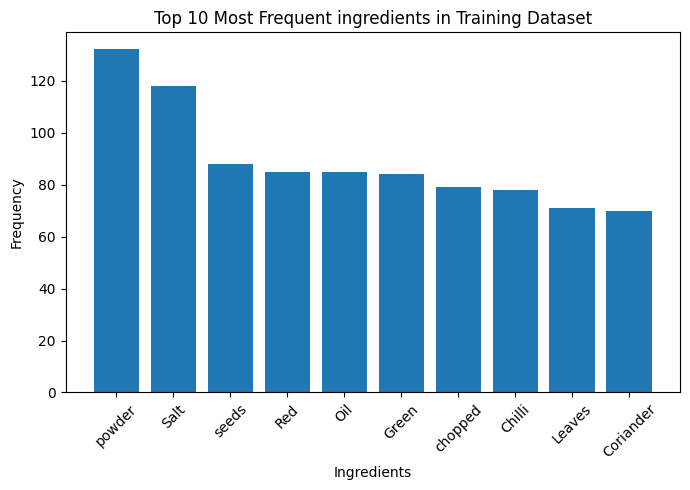

In [99]:
# plot the top frequent ingredients in training data

plot_top_items(top_ingredients_train, 'ingredients', 'Training')

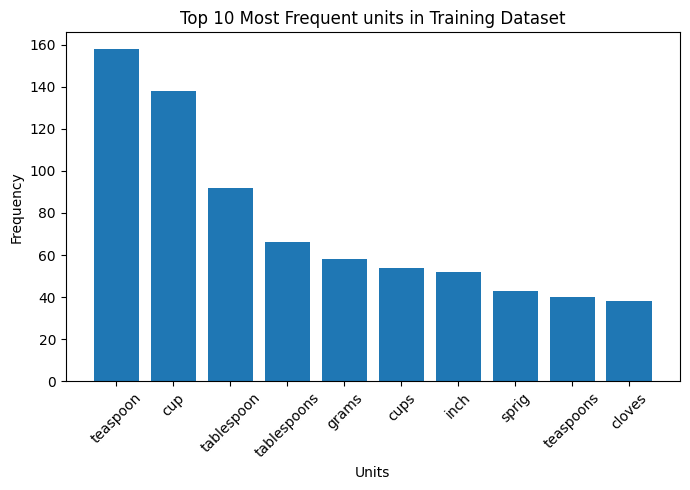

In [100]:
# plot the top frequent units in training data

plot_top_items(top_units_train, 'units', 'Training')

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [40]:
# initialise the dataset_name

dataset_name = 'Validation'


In [41]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


Top 10 most frequent ingredients in Validation dataset:
powder: 54
chopped: 38
seeds: 37
Oil: 37
Red: 36
Chilli: 35
Salt: 33
Green: 31
Garlic: 30
Cumin: 29


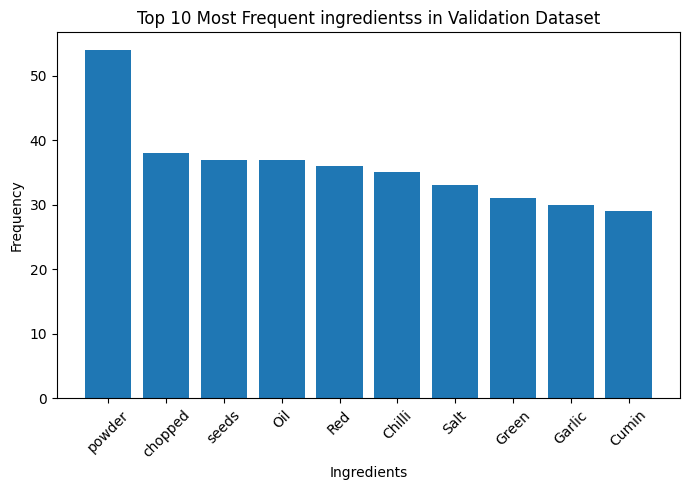

In [42]:
# plot the top frequent ingredients in validation data

top_ingredients_val = get_top_frequent_items(ingredients_val, 'ingredient', 'Validation')
plot_top_items(top_ingredients_val, 'ingredients', 'Validation')

Top 10 most frequent unitss in Validation dataset:
teaspoon: 67
cup: 60
tablespoon: 42
tablespoons: 28
grams: 25
cups: 22
sprig: 20
inch: 20
cloves: 18
teaspoons: 17


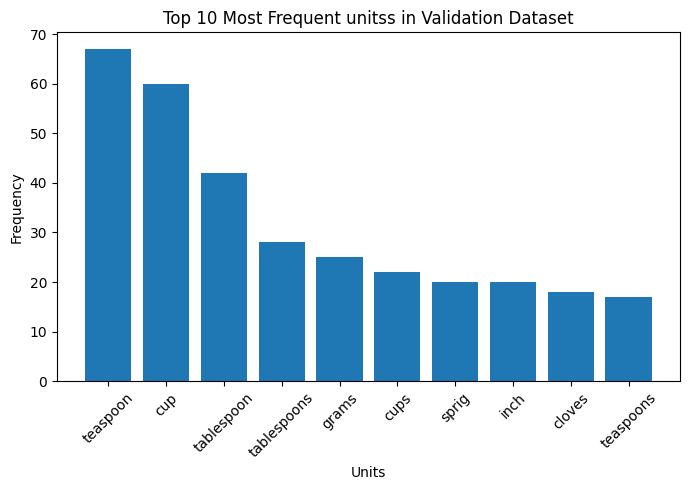

In [43]:
# plot the top frequent units in training data

top_units_val = get_top_frequent_items(units_val, 'units', 'Validation')
plot_top_items(top_units_val, 'units', 'Validation')

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [44]:
# define unit and quantity keywords along with quantity pattern

unit_keywords = {
    "cup", "cups", "tbsp", "tablespoon", "tablespoons",
    "tsp", "teaspoon", "teaspoons", "gram", "grams", "kg", "kilogram", "kilograms",
    "ml", "milliliter", "milliliters", "liter", "liters",
    "ounce", "ounces", "oz", "pound", "pounds", "lb", "lbs",
    "pinch", "pinches", "dash", "dashes", "quart", "quarts", "pint", "pints"
    }

quantity_keywords = {
    "half", "quarter", "third", "fourth", "fifth", "sixth",
    "eighth", "one", "two", "three", "four", "five", "six",
    "seven", "eight", "nine", "ten", "dozen"
    }

quantity_pattern = re.compile('\d+(\.\d+)?|\d+-\d+/\d+|\d+/\d+')
# '\d+(\.\d+)?' = decimals, e.g., 1.5 or integers, e.g., 1, 12
# '\d+-\d+/\d+' = mixed fractions, e.g., 2-1/2
# '\d+/\d+' = simple fractions, e.g., 1/2

In [45]:
# load spaCy model

nlp = spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [46]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

    # Process the entire sentence with spaCy

    # --- Core Features ---

    # --- Improved Quantity & Unit Detection ---

    # --- Contextual Features ---


def word2features(sent, i):
    """
    Extract token-level features for CRF training.
    :param sent: spaCy Doc
    :param i: token index
    :return: dict of features
    """
    token = sent[i]

    features = {
        # Core Features
        'bias': 1.0,
        'token': token.text.lower(),
        'lemma': token.lemma_.lower(),
        'pos_tag': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'shape': token.shape_,
        'is_stop': token.is_stop,
        'is_digit': token.is_digit,
        'has_digit': any(char.isdigit() for char in token.text),
        'has_alpha': any(char.isalpha() for char in token.text),
        'hyphenated': '-' in token.text,
        'slash_present': '/' in token.text,
        'is_title': token.is_title,
        'is_upper': token.is_upper,
        'is_punct': token.is_punct,

        # Improved Quantity & Unit Detection
        'is_quantity': (
            token.text.lower() in quantity_keywords or
            bool(re.fullmatch(quantity_pattern, token.text))
            ),
        'is_unit': token.text.lower() in unit_keywords,
        'is_numeric': token.like_num,
        'is_fraction': bool(re.fullmatch(r'\d+/\d+|\d+-\d+/\d+', token.text)),
        'is_decimal': bool(re.fullmatch(r'\d+\.\d+', token.text)),
        'preceding_word': sent[i - 1].text.lower() if i > 0 else '',
        'following_word': sent[i + 1].text.lower() if i < len(sent) - 1 else '',
    }

    # Contextual Features
    if i > 0:
        token1 = sent[i - 1]
        features.update({
            'prev_token': token1.text.lower(),
            'prev_is_quantity': (
                token1.text.lower() in quantity_keywords or
                bool(re.fullmatch(quantity_pattern, token1.text))
            ),
            'prev_is_digit': token1.is_digit
        })
    else:
        features['BOS'] = True

    if i < len(sent) - 1:
        token1 = sent[i + 1]
        features.update({
            'next_token': token1.text.lower(),
            'next_is_unit': token1.text.lower() in unit_keywords,
            'next_is_ingredient': (
                not (token1.text.lower() in unit_keywords or
                     token1.text.lower() in quantity_keywords or
                     bool(re.fullmatch(quantity_pattern, token1.text)))
            )
        })
    else:
        features['EOS'] = True

    return features


### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [47]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]


### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [48]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features

X_train_features = []
for sent in train_df['input']:
    doc = nlp(sent)
    X_train_features.append(sent2features(doc))

X_val_features = []
for sent in val_df['input']:
    doc = nlp(sent)
    X_val_features.append(sent2features(doc))

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [49]:
# Convert labels into list as y_train_labels and y_val_labels

y_train_labels = []
for tags in train_df['pos_tokens']:
    y_train_labels.append(tags)

y_val_labels = []
for tags in val_df['pos_tokens']:
    y_val_labels.append(tags)

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [50]:
# print the length of train features and labels

print(f"No. of training recipes (X_train_features): {len(X_train_features)}")
print(f"No. of training recipes (y_train_labels): {len(y_train_labels)}")

No. of training recipes (X_train_features): 199
No. of training recipes (y_train_labels): 199


In [51]:
X_train_features[0][:2]

[{'bias': 1.0,
  'token': '15',
  'lemma': '15',
  'pos_tag': 'NUM',
  'tag': 'CD',
  'dep': 'nummod',
  'shape': 'dd',
  'is_stop': False,
  'is_digit': True,
  'has_digit': True,
  'has_alpha': False,
  'hyphenated': False,
  'slash_present': False,
  'is_title': False,
  'is_upper': False,
  'is_punct': False,
  'is_quantity': True,
  'is_unit': False,
  'is_numeric': True,
  'is_fraction': False,
  'is_decimal': False,
  'preceding_word': '',
  'following_word': 'gawar',
  'BOS': True,
  'next_token': 'gawar',
  'next_is_unit': False,
  'next_is_ingredient': True},
 {'bias': 1.0,
  'token': 'gawar',
  'lemma': 'gawar',
  'pos_tag': 'PROPN',
  'tag': 'NNP',
  'dep': 'compound',
  'shape': 'Xxxxx',
  'is_stop': False,
  'is_digit': False,
  'has_digit': False,
  'has_alpha': True,
  'hyphenated': False,
  'slash_present': False,
  'is_title': True,
  'is_upper': False,
  'is_punct': False,
  'is_quantity': False,
  'is_unit': False,
  'is_numeric': False,
  'is_fraction': False,
  'i

In [52]:
y_train_labels[0][:2]

['quantity', 'ingredient']

In [53]:
# print the length of validation features and labels

print(f"No. of validation recipes (X_val_features): {len(X_val_features)}")
print(f"No. of validation recipes (y_val_labels): {len(y_val_labels)}")

No. of validation recipes (X_val_features): 86
No. of validation recipes (y_val_labels): 86


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [54]:
# Flatten labels in y_train

y_train_flat = list(chain.from_iterable(y_train_labels))

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [55]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts

label_counts = Counter(y_train_flat)

total_samples = sum(label_counts.values())

print("Label Counts:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

print(f"\nTotal samples (tokens): {total_samples}")


Label Counts:
quantity: 991
ingredient: 5252
unit: 833

Total samples (tokens): 7076


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [56]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts

# weight (for each label) = total_samples / freq of label

# Compute weights using inverse frequency
weight_dict = {}
for label, count in label_counts.items():
    weight = total_samples / count
    weight_dict[label] = weight


In [57]:
# penalise ingredient label

if 'ingredient' in weight_dict:
    weight_dict['ingredient'] = weight_dict['ingredient'] * 0.7

print("Class Weights:")
for label, weight in weight_dict.items():
    print(f"{label}: {weight:.4f}")


Class Weights:
quantity: 7.1403
ingredient: 0.9431
unit: 8.4946


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [58]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)

def extract_features_with_class_weights(X, y, weight_dict):

    weighted_X = []
    for recipe_features, recipe_labels in zip(X, y):
        weighted_recipe = []
        for feature_dict, label in zip(recipe_features, recipe_labels):
            feature_with_weight = feature_dict.copy()
            feature_with_weight['class_weight'] = weight_dict.get(label, 1.0)
            weighted_recipe.append(feature_with_weight)
        weighted_X.append(weighted_recipe)

    return weighted_X


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [59]:
# Apply manually computed class weights

X_train_weighted_features = extract_features_with_class_weights(X_train_features, y_train_labels, weight_dict)

X_val_weighted_features = extract_features_with_class_weights(X_val_features, y_val_labels, weight_dict)

In [60]:
X_train_weighted_features[0][:2]

[{'bias': 1.0,
  'token': '15',
  'lemma': '15',
  'pos_tag': 'NUM',
  'tag': 'CD',
  'dep': 'nummod',
  'shape': 'dd',
  'is_stop': False,
  'is_digit': True,
  'has_digit': True,
  'has_alpha': False,
  'hyphenated': False,
  'slash_present': False,
  'is_title': False,
  'is_upper': False,
  'is_punct': False,
  'is_quantity': True,
  'is_unit': False,
  'is_numeric': True,
  'is_fraction': False,
  'is_decimal': False,
  'preceding_word': '',
  'following_word': 'gawar',
  'BOS': True,
  'next_token': 'gawar',
  'next_is_unit': False,
  'next_is_ingredient': True,
  'class_weight': 7.140262361251262},
 {'bias': 1.0,
  'token': 'gawar',
  'lemma': 'gawar',
  'pos_tag': 'PROPN',
  'tag': 'NNP',
  'dep': 'compound',
  'shape': 'Xxxxx',
  'is_stop': False,
  'is_digit': False,
  'has_digit': False,
  'has_alpha': True,
  'hyphenated': False,
  'slash_present': False,
  'is_title': True,
  'is_upper': False,
  'is_punct': False,
  'is_quantity': False,
  'is_unit': False,
  'is_numeric'

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [61]:
# initialise CRF model with the specified hyperparameters and use weight_dict

# train the CRF model with the weighted training data

crf_model = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)

# Apply class weights to crf_model
crf_model.class_weights = weight_dict

# Fit the model
crf_model.fit(X_train_weighted_features, y_train_labels)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [62]:
# evaluate on the training dataset

y_train_pred = crf_model.predict(X_train_weighted_features)

In [63]:
# specify the flat classification report by using training data for evaluation

# Flatten true labels
y_train_flat = list(chain.from_iterable(y_train_labels))

# Flatten predicted labels
y_train_pred_flat = list(chain.from_iterable(y_train_pred))

In [64]:
# create a confusion matrix on training datset

labels = sorted(unique_pos_labels)
con_mat = confusion_matrix(y_train_flat, y_train_pred_flat, labels=labels)
con_mat


array([[5252,    0,    0],
       [   0,  973,   18],
       [   0,   10,  823]])

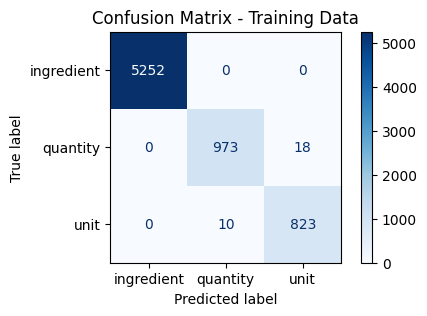

In [65]:
# Display confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=con_mat, display_labels=labels)
fig, ax = plt.subplots(figsize=(5, 3))
disp.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix - Training Data")
plt.show()


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [66]:
# dump the model using joblib as crf_model.pkl

joblib.dump(crf_model, 'crf_model.pkl')

['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [67]:
# predict the crf model on validation dataset

y_val_pred = crf_model.predict(X_val_weighted_features)

In [68]:
# specify flat classification report

# Flatten true labels
y_val_flat = list(chain.from_iterable(y_val_labels))

# Flatten predicted labels
y_val_pred_flat = list(chain.from_iterable(y_val_pred))

In [69]:
# create a confusion matrix on validation dataset

con_mat = confusion_matrix(y_val_flat, y_val_pred_flat, labels=labels)

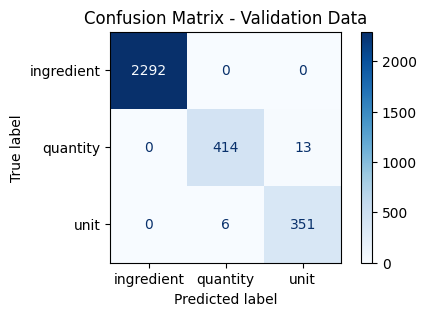

In [95]:
# Display confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=con_mat, display_labels=labels)
fig, ax = plt.subplots(figsize=(5, 3))
disp.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix - Validation Data")
plt.show()


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [85]:
# flatten Labels and Initialise Error Data

# I have already flattened true and predicted labels for validation data

# Initialise error data
error_data_val = []


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [86]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases

for recipe_features, true_labels, pred_labels in zip(X_val_weighted_features, y_val_labels, y_val_pred):
    for i, (feature_dict, true_label, pred_label) in enumerate(zip(recipe_features, true_labels, pred_labels)):

        # Check for mismatch
        if true_label != pred_label:
            token = feature_dict['token']

            # Get previous token (if not at BOS)
            if i > 0:
                prev_token = recipe_features[i - 1]['token']
            else:
                prev_token = ''

            # Get next token (if not at EOS)
            if i < len(recipe_features) - 1:
                next_token = recipe_features[i + 1]['token']
            else:
                next_token = ''

            # Get class weight
            class_weight = feature_dict['class_weight']

            # Store error data
            error_data_val.append({
                'token': token,
                'true_label': true_label,
                'predicted_label': pred_label,
                'prev_token': prev_token,
                'next_token': next_token,
                'class_weight': class_weight
            })


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [87]:
# Create DataFrame and Print Overall Accuracy

error_df_val = pd.DataFrame(error_data_val)
print('Validation error data:')
print(error_df_val)

print()
print("--------------------------------------------------------------------")
print()

# Accuracy - Validation data 
accuracy = (len(y_val_flat) - len(error_df_val)) / len(y_val_flat)
print(f"Overall Validation Accuracy: {accuracy:.4f}")


Validation error data:
         token true_label predicted_label prev_token   next_token  class_weight
0       powder   quantity            unit          -      mustard      7.140262
1        small       unit        quantity     chilli        spoon      8.494598
2      chilled   quantity            unit       seed                   7.140262
3           10       unit        quantity          -        mixed      8.494598
4        grams   quantity            unit        500     tomatoes      7.140262
5     tomatoes   quantity            unit      grams            8      7.140262
6            8       unit        quantity   tomatoes            2      8.494598
7      crushed   quantity            unit      corns        sugar      7.140262
8         curd   quantity            unit      puree     cinnamon      7.140262
9          red       unit        quantity     powder       chilli      8.494598
10          to   quantity            unit         10           12      7.140262
11           4   

In [88]:
# error data of training set

error_data_train = []

for recipe_features, true_labels, pred_labels in zip(X_train_weighted_features, y_train_labels, y_train_pred):
    for i, (feature_dict, true_label, pred_label) in enumerate(zip(recipe_features, true_labels, pred_labels)):

        # Check for mismatch
        if true_label != pred_label:
            token = feature_dict['token']

            # Get previous token (if not at BOS)
            if i > 0:
                prev_token = recipe_features[i - 1]['token']
            else:
                prev_token = ''

            # Get next token (if not at EOS)
            if i < len(recipe_features) - 1:
                next_token = recipe_features[i + 1]['token']
            else:
                next_token = ''

            # Get class weight
            class_weight = feature_dict['class_weight']

            # Store error data
            error_data_train.append({
                'token': token,
                'true_label': true_label,
                'predicted_label': pred_label,
                'prev_token': prev_token,
                'next_token': next_token,
                'class_weight': class_weight
            })

error_df_train = pd.DataFrame(error_data_train)
print('Training error data:')
print(error_df_train)

print()
print("--------------------------------------------------------------------")
print()

# Accuracy - Training Data
accuracy = (len(y_train_flat) - len(error_df_train)) / len(y_train_flat)
print(f"Overall Training Accuracy: {accuracy:.4f}")

Training error data:
         token true_label predicted_label prev_token  next_token  class_weight
0          cut       unit        quantity     french        into      8.494598
1     cardamom   quantity            unit      black        badi      7.140262
2   pistachios       unit        quantity     almond       garam      8.494598
3       masala   quantity            unit      garam         oil      7.140262
4            -   quantity            unit          1           1      7.140262
5        paste   quantity            unit     garlic         1.5      7.140262
6       minced   quantity            unit      onion         1/3      7.140262
7     powdered   quantity            unit     salted           1      7.140262
8      peanuts       unit        quantity        raw  moongphali      8.494598
9            1       unit        quantity       cups           -      8.494598
10        gram   quantity            unit     bengal         dal      7.140262
11      cloves   quantity      

In [94]:
# Accuracy - Training Data
accuracy = (len(y_train_flat) - len(error_df_train)) / len(y_train_flat)
print(f"Overall Training Accuracy: {accuracy:.4f}")

Overall Training Accuracy: 0.9960


So, we have almost equal accuracy score of training and validation set.<Br>

**Training accuracy = 99.60%**<Br>

**Validation accuracy = 99.38%**<Br>

These are pretty good numbers in terms of accuracy.

In [93]:
# correctly predicted data of training set

correct_data_train = []

for recipe_features, true_labels, pred_labels in zip(X_train_weighted_features, y_train_labels, y_train_pred):
    for i, (feature_dict, true_label, pred_label) in enumerate(zip(recipe_features, true_labels, pred_labels)):

        # Check for mismatch
        if true_label == pred_label:
            token = feature_dict['token']

            # Get previous token (if not at BOS)
            if i > 0:
                prev_token = recipe_features[i - 1]['token']
            else:
                prev_token = ''

            # Get next token (if not at EOS)
            if i < len(recipe_features) - 1:
                next_token = recipe_features[i + 1]['token']
            else:
                next_token = ''

            # Get class weight
            class_weight = feature_dict['class_weight']

            # Store error data
            correct_data_train.append({
                'token': token,
                'true_label': true_label,
                'predicted_label': pred_label,
                'prev_token': prev_token,
                'next_token': next_token,
                'class_weight': class_weight
            })

correct_df_train = pd.DataFrame(correct_data_train)
print('First 25 Correctly predicted labels in training data:')
print(correct_df_train[:25])

First 25 Correctly predicted labels in training data:
            token  true_label predicted_label     prev_token     next_token  class_weight
0              15    quantity        quantity                         gawar      7.140262
1           gawar  ingredient      ingredient             15          phali      0.943107
2           phali  ingredient      ingredient          gawar  kothavarangai      0.943107
3   kothavarangai  ingredient      ingredient          phali        cluster      0.943107
4         cluster  ingredient      ingredient  kothavarangai          beans      0.943107
5           beans  ingredient      ingredient        cluster              1      0.943107
6               1    quantity        quantity          beans           inch      7.140262
7            inch        unit            unit              1         ginger      8.494598
8          ginger  ingredient      ingredient           inch              4      0.943107
9               4    quantity        quantity 

##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [ ]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

error_df_val = pd.DataFrame(error_data_val)
print('Validation error data:')
print(error_df_val)

print()
print("--------------------------------------------------------------------")
print()

# Accuracy - Validation data 
accuracy = (len(y_val_flat) - len(error_df_val)) / len(y_val_flat)
print(f"Overall Validation Accuracy: {accuracy:.4f}")

Validation error data:
         token true_label predicted_label prev_token   next_token  class_weight
0       powder   quantity            unit          -      mustard      7.140262
1        small       unit        quantity     chilli        spoon      8.494598
2      chilled   quantity            unit       seed                   7.140262
3           10       unit        quantity          -        mixed      8.494598
4        grams   quantity            unit        500     tomatoes      7.140262
5     tomatoes   quantity            unit      grams            8      7.140262
6            8       unit        quantity   tomatoes            2      8.494598
7      crushed   quantity            unit      corns        sugar      7.140262
8         curd   quantity            unit      puree     cinnamon      7.140262
9          red       unit        quantity     powder       chilli      8.494598
10          to   quantity            unit         10           12      7.140262
11           4   

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

**Insights:**
- Accuracy on validation dataset = 99.38%
- Accuracy on training dataset = 99.60%
- Our model is performing very well. No underfitting or overfitting.
- All 'ingredient' labels have been predicted correctly in both training and validation data.
- As we can see in above error_df_val, some tokens like 'powder', 'chilled' are lebelled as quantity in true_label which is inncorrect which means we are providing incorrect true labels.
- Similarly, some tokens like '10', '8', '4' are labelled as unit in true_labels instead of quantity and our model is predicting them as quantity which is actually true, but since these are provided with incorrect labels, hence these are included in errors. So, the model is outperforming noisy labels — which is excellent.
- Overall, the model has learned well and generalizes accurately despite minor inconsistencies in the training data.


## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.

- The CRF model has learned the sequence structure very well with an overall validation accuracy of 99.38%, and training accuracy of 99.60%.
- Some of the errors are due to noisy label, not true misclassification.
- All 'ingredient' labels (which are the bulk of the data) have been predicted correctly in both training and validation data.
